# Backest on 6 month range of Test with PC mdl XGB 14 Best Mdl  > 333$ on 3 month Test

- For HCV : 500 candidates
  - use classical ressources = samples with min 90 days 
  - large search hyperparam
  - validation on 60 days only (instead of 232)
- Find best : 
  - Select best model with several criteria from HCV : 
    - rank highest : best behaviour at different time range so best generalization 
    - best low std_test_score and std_train_score
    - best high  split2_test_score & split2_train_score
  - Eval these model on 4000 rounds 
    - keep only mdl with highest gain > 333$/month on Test and Train

- Results


## Import & definitions

In [1]:
import os
# import hashlib
import sys
import subprocess
import pathlib
# from pathlib import Path
# import re
# import random
# import time
# import math
# import itertools
# from datetime import timedelta
# from datetime import timezone
# from datetime import datetime
# import json
# import joblib
# Third Party
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import make_scorer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split 
# from sklearn.preprocessing import StandardScaler
# from sklearn.experimental import enable_halving_search_cv  # noqa: F401
# from sklearn.model_selection import HalvingRandomSearchCV
# from sklearn.model_selection import TimeSeriesSplit
# from scipy.stats import randint
# from scipy.stats import uniform
# import scipy.stats as stats
# from scipy.stats.mstats import mquantiles
# import xgboost as xgb
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
# import matplotlib.pyplot as plt
# import matplotlib as mpl
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.9 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True
target_level = 0.0045 
R = 2 
risk = 250
R_eq = 1.23
gain_period_min = 333
gain_period_bingo = 1000

# paths
path_data = "data/update"
path_data_old = "data"

# path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

# path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
# path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")
# path_scaler = os.path.join(path_data, "scaler.bin")
# path_scaler_y = os.path.join(path_data, "scaler_y.bin")
# path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
# path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
# path_X_train = os.path.join(path_data, 'X_train.dat')
# path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
# path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
# path_df_prob_comb_2 = os.path.join(path_data, 'df_prob_comb_2.csv')
# path_df_prob_comb_1b = os.path.join(path_data, 'df_prob_comb_1b.csv')
# path_arr_corr_matrix_targets = os.path.join(
#     path_data, 'arr_corr_matrix_targets.npy'
# )
# path_pca = os.path.join(path_data,"pca_model.pkl")
# path_hash_pca = os.path.join(path_data, 'pca_hash.txt')


## Load 

In [2]:
# LOAD
#df_prob_comb_high_event = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event.pkl'))
#global_event_by_day = pd.read_pickle(os.path.join(path_data, 'global_event_by_day.pkl'))
df_combined_condition = pd.read_pickle(os.path.join(path_data_old, 'df_combined_condition.pkl'))
#df_prob_comb_high_event_test = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event_test.pkl'))
#global_event_by_day_test = pd.read_pickle(os.path.join(path_data, 'global_event_by_day_test.pkl'))
df_combined_condition_test = pd.read_pickle(os.path.join(path_data, 'df_combined_condition_test.pkl'))

df_targets = pd.read_pickle(os.path.join(path_data_old, "df_targets.pkl"))
df_targets_test = pd.read_pickle(os.path.join(path_data, "df_targets_test.pkl"))

with open(os.path.join(path_data_old, "list_df.pkl"), "rb") as f:
    list_df = pickle.load(f)

with open(os.path.join(path_data, "list_df_test.pkl"), "rb") as f:
    list_df_test = pickle.load(f)


In [3]:
# X train : df_combined_condition train
# X test: df_combined_condition_test

# Y train : high trade or not
y_comb = (list_df[0]["target_cat"] == "high")
# Y test 
y_comb_test = list_df_test[0]["target_cat"] == "high"

In [4]:
np.all(list_df_test[0]["target_cat"].values == df_targets_test["target_cat"].values)

np.True_

In [5]:
# print date TRAIN start end + nb days
start_train = list_df[0].index[0]
end_train = list_df[0].index[-1]
start_test = list_df_test[0].index[0]
end_test = list_df_test[0].index[-1]

days_train = (end_train - start_train).days
days_test = (end_test - start_test).days

print("TRAIN:", start_train, "->", end_train, f"({days_train} days)")
print("TEST: ", start_test, "->", end_test, f"({days_test} days)")

TRAIN: 2023-01-01 00:00:00 -> 2025-07-20 04:50:00 (931 days)
TEST:  2025-07-20 12:10:00 -> 2026-01-23 03:40:00 (186 days)


## Functions

In [6]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [7]:
def fun_trade(total_trades, winrate, risk=250, R=1.23 ):
    return total_trades * risk * (winrate * (1 + R) - 1)

def fun_arr_trade(arr_trade, arr_winrate, risk=250, R=1.23):
    return arr_trade * risk * (arr_winrate * (1 + R) - 1)

def fun_trades_gain(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    risk = 250
    R = 1.23
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    if y_pred.sum() == 0:
        return 0.0
    
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    winrate = precision_score(y_true, y_pred)
    #total_gain = total_trades * risk * (winrate * (1 + R) - 1)
    total_gain = fun_trade(total_trades, winrate, risk, R )
    # XGBoost custom metrics must return a list of (name, value) tuples
    return total_gain #precision_score(y_true, y_pred) + 10*float(total_trades)


In [8]:
def fun_plot_trades_gain(arr_eval, arr_eval_train, title_str="XBGBoost model performance : total gain"):
    fig = make_subplots(
        rows=2, 
        cols=1, 
        shared_xaxes=True, 
        vertical_spacing=0.03
    )

    fig.add_trace(
        go.Scatter(y=arr_eval["fun_trades_gain"], name="total_gain test"),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(y=arr_eval_train["fun_trades_gain"], name="total_gain train"),
        row=1,
        col=1,
    )
    fig.update_layout(
        height=600,
        template="plotly_white",
        title=title_str,
        hovermode='x unified'
    )
    fig.update_xaxes(
        showspikes=True, 
        spikemode='across', 
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot'
    )

    # Optional: Add y-axis spikes for more context
    fig.update_yaxes(showspikes=True, spikedash='dot')

    fig.show()

In [9]:
def fun_decoded_nb_trade_fixed_window(arr_in):
    # arr_in = np.array(precision_score(y_true, y_pred) + 10*float(total_trades))
    return np.int64(arr_in/10), arr_in%10

def fun_winrate(nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (nb_trade * risk)+1) /(1 + R)

def fun_arr_winrate(arr_nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (arr_nb_trade * risk)+1) /(1 + R)


In [10]:
def plot_trading_performance(df_trades, df_feat_tot, monthly_target=333):
    """
    V1.1
    Generates an interactive Plotly chart analyzing trading performance.

    Args:
        df_trades (pd.DataFrame): DataFrame with columns 'capital' and 'Train' (bool).
                                  Index must be DatetimeIndex.
        df_feat_tot (pd.DataFrame): DataFrame with column 'Close_ETH_raw'.
                                    Index must be DatetimeIndex.
        monthly_target (float): Target monthly gain in $ for the benchmark curve.
                                Default is 333.

    Returns:
        plotly.graph_objects.Figure: The generated figure.
    """
    
    # --- 1. Calculate Global Statistics for Title ---
    
    # Split the data
    df_train = df_trades[df_trades["Train"]]
    df_test = df_trades[~df_trades["Train"]]

    # Constants
    SECONDS_PER_MONTH = 30.44 * 24 * 60 * 60

    def calculate_mean_monthly_gain(df):
        if df.empty: return 0
        total_pnl = df["capital"].iloc[-1] - df["capital"].iloc[0]
        duration = (df.index[-1] - df.index[0]).total_seconds()
        if duration > 0:
            # PnL / (Duration in Months)
            return total_pnl / (duration / SECONDS_PER_MONTH)
        return 0

    mean_train_gain = calculate_mean_monthly_gain(df_train)
    mean_test_gain = calculate_mean_monthly_gain(df_test)

    plot_title = (
        f"<span style='font-size: 14px;'>Global Mean Monthly Gain: "
        f"<b>Train ${mean_train_gain:,.2f}/mo</b> | "
        f"<b>Test ${mean_test_gain:,.2f}/mo</b></span>"
    )

    # --- 2. Calculate Monthly Metrics ---

    # A. Monthly Reset Min Gain Curve
    # Groups by month, starts at actual capital, adds linear growth of monthly_target
    min_gain_pieces = []
    for period, group in df_trades.groupby(pd.Grouper(freq='MS')):
        if group.empty: continue
        start_capital = group.iloc[0]['capital']
        start_date = group.index[0]
        time_elapsed = (group.index - start_date).total_seconds()
        monthly_values = start_capital + (time_elapsed / SECONDS_PER_MONTH) * monthly_target
        min_gain_pieces.append(pd.Series(monthly_values, index=group.index))

    min_gain_series = pd.concat(min_gain_pieces) if min_gain_pieces else pd.Series(dtype=float)

    # B. Monthly Return (Absolute $)
    # Corrected logic: Last capital of current month - Last capital of previous month (or 0)
    # We use resample to get the last capital of each month and ffill to handle months without trades.
    monthly_ends = df_trades['capital'].resample('MS').last().ffill()
    monthly_return_abs = monthly_ends - monthly_ends.shift(1).fillna(0)

    # C. Monthly Max Drawdown (%)
    monthly_drawdown_pct = df_trades.groupby(pd.Grouper(freq='MS'))['capital'].apply(
        lambda x: (x / x.cummax() - 1).min() * 100 if len(x) > 0 else 0
    )

    # --- 3. Create Subplots ---
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        row_heights=[0.60, 0.40],
        # Enable secondary_y for both rows to handle different scales
        specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
        subplot_titles=("Capital vs. Targets", "Monthly Performance: Drawdown (%) vs Return ($)")
    )

    # --- 4. Row 1: Capital & ETH ---

    # Train Capital
    if not df_train.empty:
        fig.add_trace(go.Scatter(
            x=df_train.index,
            y=df_train["capital"],
            mode='lines+markers',
            name='Train Capital',
            line=dict(width=1),
            marker=dict(size=3)
        ), row=1, col=1)

    # Test Capital
    if not df_test.empty:
        fig.add_trace(go.Scatter(
            x=df_test.index,
            y=df_test["capital"],
            mode='lines+markers',
            name='Test Capital',
            line=dict(width=1),
            marker=dict(size=3)
        ), row=1, col=1)

    # Min Gain Benchmark
    fig.add_trace(go.Scatter(
        x=min_gain_series.index,
        y=min_gain_series,
        mode='lines',
        name=f'Min Gain (${monthly_target}/mo)',
        line=dict(color='green', width=2, dash='solid'),
        opacity=0.6
    ), row=1, col=1)

    # ETH Price (Secondary Y-Axis)
    fig.add_trace(go.Scatter(
        x=df_feat_tot.index,
        y=df_feat_tot["Close_ETH_raw"],
        mode='lines',
        name='ETH Price',
        line=dict(color='grey', width=1, dash='dot')
    ), row=1, col=1, secondary_y=True)

    # --- 5. Row 2: Drawdown (%) & Return ($) ---

    # Trace 1: Max Drawdown % (Left Axis)
    fig.add_trace(go.Bar(
        x=monthly_drawdown_pct.index,
        y=monthly_drawdown_pct.values,
        name='Max Drawdown %',
        marker_color='crimson',
        opacity=0.4,
        text=[f"{val:.1f}%" for val in monthly_drawdown_pct.values],
        textposition='inside',
        textfont=dict(size=11, color='white'),
        hovertemplate='%{x|%b %Y}<br>Drawdown: %{y:.2f}%<extra></extra>'
    ), row=2, col=1, secondary_y=False)

    # Trace 2: Monthly Return $ (Right Axis)
    # Color logic: Green for positive, Red for negative
    colors = ['#00CC96' if val >= 0 else '#EF553B' for val in monthly_return_abs.values]

    fig.add_trace(go.Bar(
        x=monthly_return_abs.index,
        y=monthly_return_abs.values,
        name='Monthly Return $',
        marker_color=colors,
        opacity=0.8,
        text=[f"{val:+.0f}$" for val in monthly_return_abs.values],
        textposition='outside',
        textangle=-90,
        textfont=dict(size=14, color='green'),
        cliponaxis=False,
        hovertemplate='%{x|%b %Y}<br>PnL: %{y:+.2f}$<extra></extra>'
    ), row=2, col=1, secondary_y=True)

    # --- 6. Update Layout ---
    fig.update_layout(
        title=plot_title,
        width=1200,
        height=700,
        template="plotly_white",
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(b=100) # Extra bottom margin for vertical text
    )

    # Row 1 Axes Labels
    fig.update_yaxes(title_text="Capital [$]", row=1, col=1, secondary_y=False)
    fig.update_yaxes(title_text="ETH Price [$]", row=1, col=1, secondary_y=True)

    # Row 2 Axes Labels & Styling
    fig.update_yaxes(title_text="Drawdown [%]", row=2, col=1, secondary_y=False, color='crimson')
    fig.update_yaxes(title_text="Monthly Return [$]", row=2, col=1, secondary_y=True, color='black')
    
    # Add a zero line for the return chart
    fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', row=2, col=1)

    return fig


In [11]:
def fun_arr_winrate(arr_nb_trade, gain, risk, R):
    """Mock function to simulate win rate calculation."""
    # This is a placeholder to make the example runnable.
    # The formula is derived from a common trading gain formula.
    return (gain / arr_nb_trade + risk) / (risk * (1 + R))

# --- Updated plotting function ---

def fun_plot_pre_trade(df, gain_period_min=333, gain_period_bingo=1000):

    arr_nb_trade_winrate_train = np.linspace(max(1, min(df["trades_train"])), max(df["trades_train"]), 100)
    arr_winrate_min_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_min, risk=250, R=1.23)
    arr_winrate_bingo_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_bingo, risk=250, R=1.23)

    # --- Create the Plot with opacity for the test data ---
    fig = px.scatter(
        df,
        x='trades_test',
        y='precision_test',
        title="Evaluation Precision vs. Number of Trades",
        color_discrete_sequence=["#3CB620"], # Green for test data
        opacity=0.6,  # Added opacity for the main scatter plot
    )
    # Customize the hover template
    fig.update_traces(
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "Gain Train: %{customdata[1]:.2f}<br>" +
                "Trades Train: %{customdata[3]:.2f}<br>" +
                "Winrate Train: %{customdata[4]:.4f}<br>" +
                "<b>Gain Test: %{customdata[2]:.2f}</b><br>" +
                "Trades Test: %{x:.2f}<br>" +
                "Winrate Test: %{y:.4f}<br>" + # Corrected from Winrate Train
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_train", "precision_train"]],
            name="test" # Assign a name for the legend
    )

    # add precision = f(nb_trade) to have a gain = 333/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_min_train,
        mode='lines',
        line=dict(color='red', width=2),
        line_dash="dash",
        name="333$/mth Precision",
        hovertemplate=f"Gain: {gain_period_min:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add precision = f(nb_trade) to have a gain = 1000/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_bingo_train,
        mode='lines',
        line=dict(color='blue', width=2),
        line_dash="dash",
        name="1000$/mth Precision",
        hovertemplate=f"Gain: {gain_period_bingo:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add train data with opacity
    fig.add_trace(
        go.Scatter(
            x=df["trades_train"],
            y=df["precision_train"],
            name="train",
            mode="markers",
            # Added marker dict to set color and opacity for the train data
            marker=dict(
                color="#FF7F0E", # Orange for train data
                opacity=0.6
            ),
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "<b>Gain Train: %{customdata[1]:.2f}</b><br>" +
                "Trades Train: %{x:.2f}<br>" +
                "Winrate Train: %{y:.4f}<br>" +
                "Gain Test: %{customdata[2]:.2f}<br>" +
                "Trades Test: %{customdata[3]:.2f}<br>" +
                "Winrate Test: %{customdata[4]:.4f}<br>" +
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_test", "precision_test"]],
        )
    )

    fig.update_layout(
        xaxis_title="Number of Trades / mth",
        yaxis_title="Precision",
        font=dict(family="Arial, sans-serif", size=14),
        height=600,
        legend_title_text='Data Type' # Add a title to the legend
    )

    fig.show()



In [12]:
def fun_plot_xgb_rounds(df, gain_period_min=333, gain_period_bingo=1000):
    """
    Plots XGBoost model performance with semi-transparent markers.
    """
    layout = dict(
        hoversubplots="axis",
        title=dict(text="XBGBoost model performance"),
        hovermode="x",
        grid=dict(rows=3, columns=1),
        height=600,
        xaxis_title="XGB Rounds",
        yaxis=dict(
            title="Trades"
        ),
        yaxis2=dict(
            title="Precision"
        ),
        yaxis3=dict(
            title="Gain"
        )
    )

    # Define marker styles for train and test to reduce repetition
    # The 'opacity' property (from 0 to 1) controls the alpha effect.
    train_marker = dict(color="blue", opacity=0.5)
    test_marker = dict(color="red", opacity=0.5)

    data = [
        go.Scatter(x=df["run_index"], y=df["trades_train"], xaxis="x", yaxis="y", name="trades train", mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["trades_test"], xaxis="x", yaxis="y", name="trades test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["precision_train"], xaxis="x", yaxis="y2", name="pre train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["precision_test"], xaxis="x", yaxis="y2", name="pre test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["gain_train"], xaxis="x", yaxis="y3", name="gain train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["gain_test"], xaxis="x", yaxis="y3", name="gain test",  mode="markers", marker=test_marker),
    ]

    fig = go.Figure(data=data, layout=layout)

    fig.add_hline(
        y=gain_period_min,
        xref="x",
        yref="y3",
        line_dash="dot",
        line=dict(color='red', width=2),
        annotation_text=f"Gain: {gain_period_min:.2f}$/mth",
        annotation_position="bottom right",
        annotation_font_color="red",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.add_hline(
        y=gain_period_bingo,
        xref="x",
        yref="y3",
        line_dash="dot",
        annotation_text=f"Gain: {gain_period_bingo:.2f}$/mth",
        annotation_position="top right",
        annotation_font_color="blue",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.update_xaxes(
        showspikes=True,
        spikemode='across',
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot',
    )
    fig.show()




In [13]:
def sum_upfront_1h(arr_in):
    """
    Calculates the number of rising edges in a pandas Series for one hour limited to 1

    A rising edge is defined as a transition from 0 to 1.

    Args:
        ser_in: A pandas Series containing numerical data (presumably 0s and 1s).

    Returns:
        The total count of rising edges (0 to 1 transitions).
    """

    previous_values = arr_in.shift(1, fill_value=0)

    rising_edges = (arr_in == 1) & (previous_values == 0)

    if rising_edges.sum() >= 1:
        return 1
    else:
      return 0


In [14]:
def open_webpage_in_chrome(url_curr):

    # 1. Obtenir le répertoire de travail actuel (où se trouve le notebook)
    current_dir = os.getcwd()

    # 2. Construire le chemin complet vers le fichier HTML
    # os.path.join est utilisé pour s'assurer que le chemin est correct quel que soit l'OS (Windows, macOS, Linux)
    file_path = os.path.join(current_dir, url_curr)

    # 3. Convertir le chemin du fichier en une URI (ex: file:///C:/Users/...)
    # C'est la méthode la plus fiable pour que les navigateurs ouvrent un fichier local
    url = pathlib.Path(file_path).as_uri()

    print(f"Tentative d'ouverture du fichier : {url}")

    # Le reste du code reste inchangé, il utilise la nouvelle 'url'
    if sys.platform.startswith("win"):
        try:
            chrome = r"C:\Program Files\Google\Chrome\Application\chrome.exe"
            DETACHED = subprocess.DETACHED_PROCESS | subprocess.CREATE_NEW_PROCESS_GROUP
            subprocess.Popen([chrome, "--new-tab", url],
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL,
                            creationflags=DETACHED)
        except FileNotFoundError:
            print("Google Chrome non trouvé à l'emplacement par défaut. Tentative avec le lanceur système.")
            os.startfile(file_path)

    elif sys.platform == "darwin":  # macOS
        subprocess.Popen(["open", "-a", "Google Chrome", url],
                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    else:  # Linux
        try:
            subprocess.Popen(["google-chrome", "--new-tab", url],
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL,
                            start_new_session=True)
        except FileNotFoundError:
            print("google-chrome non trouvé. Essayez avec 'chromium-browser'.")
            try:
                subprocess.Popen(["chromium-browser", "--new-tab", url],
                                stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL,
                                start_new_session=True)
            except FileNotFoundError:
                print("chromium-browser non trouvé non plus.")

In [15]:
def backtest(df_, capital_init, step_max, 
             tp_ratio, risk_ratio, ratio_fees, R,
             trade_signal=None):
    # leverage calculation 
    #leverage = (capital_init * risk_ratio * R / tp_ratio) / capital_init
    leverage = risk_ratio /  (tp_ratio / R + ratio_fees * (1 - tp_ratio / (2 * R)))
    print('leverage [-]: ', leverage)

    # TP calculation
    fees_tp = ((1+tp_ratio) + 1) / 2 * leverage * capital_init * ratio_fees
    gain_tp = tp_ratio * leverage * capital_init - fees_tp
    # SL calculation
    fees_sl = (1 + 1-1/R*tp_ratio) / 2 * leverage * capital_init * ratio_fees
    gain_sl = -1/R*tp_ratio * leverage * capital_init - fees_sl
    print("Gain for one TP [$]: ", gain_tp)
    print("Loss for one SL [$]: ", gain_sl)
    # simulation: initialisation
    if trade_signal is None:
        buy = df_["Close_ETH_raw"].values[0] # for first trade
        list_buy = [buy]
        list_trade_date_open = [df_["Close_ETH_raw"].index[0]]
        neutral = False
    else:
        list_buy = []
        list_trade_date_open = []
        neutral = True
    tp = False
    nb_tp = 0
    capital_tp = 0
    sl = False
    nb_sl = 0
    capital_sl = 0
    
    nb_neutral = 0
    capital_neutral = 0
    capital = capital_init
    step = 0
    list_trade_gain = []
    list_trade_date = []
    list_trade_type = []
    list_trade_fees = []
    list_capital = []
    list_sell = []
    
    #list_buy.append(buy)
    # simulation calculation
    for close, high, low, date_trade in zip(
            df_["Close_ETH_raw"], 
            df_["Close_ETH_raw"] * df_["High_ETH"], 
            df_["Close_ETH_raw"] * df_["Low_ETH"],
            df_["Close_ETH_raw"].index
        ):
        
        # NEUTRAL : if elasted time to take a trade is over (more than 1 hour) : we close the position
        if step >= step_max:
            nb_neutral += 1
            fees = ( (buy + close) / 2 ) / buy * leverage * capital_init * ratio_fees
            gain = ((close - buy) / buy) * leverage * capital_init - fees
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append(close)
            list_trade_type.append("Neutral")
            capital += gain
            list_capital.append(capital)
            capital_neutral += gain
            neutral = True
            step = 0
            continue

        # if trade_signal is not None:
        #     if trade_signal.at[date_trade] == True:
        #         print("Trade possible at ", date_trade)

        # if last time, we have close a position or no trade opened
        if tp or sl or neutral:
            if trade_signal is not None:
                try:
                    if trade_signal.at[date_trade] == True:
                        pass
                except:
                    print(date_trade, "is not in trade_signal")

            # if no signal used,  we open a new one immediatly (5 min after)
            if trade_signal is None:
                buy = close
                list_trade_date_open.append(date_trade)
                list_buy.append(buy)
                step = 0
                tp = False
                sl = False
                neutral = False
                continue # trade done at close
            # if trade signal is True
            elif np.any(trade_signal.at[date_trade]):
                #print("Trade opened at ", date_trade)
                buy = close
                list_trade_date_open.append(date_trade)
                list_buy.append(buy)
                step = 0
                tp = False
                sl = False
                neutral = False
                continue # trade done at close
            # if no trade signal => no trade opened
            else:
                tp = False
                sl = False
                neutral = True # to be able to check next time
                step = 0
                continue
        # TP : if max price is higher than TP, we take the trade and close position
        if high >= (1+tp_ratio) * buy:
            fees = fees_tp
            gain = gain_tp
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append((1+tp_ratio)*buy)
            list_trade_type.append("TP")
            capital += gain
            list_capital.append(capital)
            capital_tp += gain
            tp = True
            nb_tp += 1
            continue
        # SL : if min price is lower than SL, we take the trade and close position
        elif low <= (1-1/R*tp_ratio) * buy: 
            fees = fees_sl
            gain = gain_sl
            list_trade_fees.append(fees)
            list_trade_gain.append(gain)
            list_trade_date.append(date_trade)
            list_sell.append((1-1/R*tp_ratio)*buy)
            list_trade_type.append("SL")
            capital +=  gain
            list_capital.append(capital)
            capital_sl +=  gain
            sl = True
            nb_sl += 1
            continue
        # no trade
        else:
            step += 1
    # results
    if trade_signal is not None:
        print("trade signal used, adding last buy & date_open")
        list_trade_date_open.append(df_["Close_ETH_raw"].index[-1])
        #list_buy.append(buy)
    if len(list_buy) > len(list_trade_date):
        list_buy = list_buy[:len(list_trade_date)]
    if len(list_trade_date_open) > len(list_trade_date):
        list_trade_date_open = list_trade_date_open[:len(list_trade_date)]
    df_trades = pd.concat([
        pd.Series(list_trade_type, index=list_trade_date, name="type"),
        pd.Series(list_trade_date_open, index=list_trade_date, name="date_open"),
        pd.Series(list_buy, index=list_trade_date, name="buy"),
        pd.Series(list_sell, index=list_trade_date, name="sell"),
        pd.Series(list_trade_gain, index=list_trade_date, name="gain"),
        pd.Series(list_trade_fees, index=list_trade_date, name="fees"),
        pd.Series(list_capital, index=list_trade_date, name="capital"),
        ],
        axis=1,
    )
    return df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral

In [16]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
# Best Score (Accuracy): 0.3451
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177
best_params_= {}
best_params_["colsample_bytree"] = 0.4145
best_params_["learning_rate"] = 0.5959
best_params_["max_depth"] = 2
best_params_["reg_alpha"] = 0.0718
best_params_["reg_lambda"] = 0.6826
best_params_["subsample"] = 0.4177


## XGBoost

### Backtest

In [17]:
df_feat_tot = pd.concat((list_df[0], list_df_test[0]))

In [18]:
gain_period_min = 333
gain_period_bingo = 1000

r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

#### Baseline

target level for TP [-]:  0.0045
R TP/SL [-]:  2
r_fees %fees/%TP [-]:  0.17200000000000001
R_eq [-]:  1.2321428571428572
leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
Capital init [$] 10000
final capital [$]: -3042180.0579067674
ratio gain final [-]:  -305.2180057906767
Winrate [-] :  0.29416912394178635
nb_tp:  15463
capital_tp [$]:  4762301.279831684
nb_sl:  31552
capital_sl [$]:  -7888000.0
nb_neutral:  5550
capital_neutral [$] 73518.66226157876


,type,date_open,buy,sell,gain,fees,capital
2023-01-01 01:15:00,Neutral,2023-01-01 00:00:00,1194.540039,1194.369995,-75.773794,64.001970,9.924226e+03
2023-01-01 02:40:00,Neutral,2023-01-01 01:20:00,1193.660034,1195.109985,36.406005,64.045400,9.960632e+03
2023-01-01 04:05:00,Neutral,2023-01-01 02:45:00,1194.290039,1196.010010,55.042660,64.052616,1.001567e+04
2023-01-01 05:30:00,Neutral,2023-01-01 04:10:00,1195.829956,1196.160034,-41.189318,64.015359,9.974486e+03
2023-01-01 06:55:00,Neutral,2023-01-01 05:35:00,1196.170044,1197.160034,4.408765,64.033013,9.978894e+03
...,...,...,...,...,...,...,...
2026-01-23 02:25:00,SL,2026-01-23 01:30:00,2947.250000,2940.618687,-250.000000,63.934518,-3.041180e+06
2026-01-23 02:35:00,SL,2026-01-23 02:30:00,2937.270000,2930.661143,-250.000000,63.934518,-3.041430e+06
2026-01-23 03:00:00,SL,2026-01-23 02:40:00,2930.120000,2923.527230,-250.000000,63.934518,-3.041680e+06
2026-01-23 03:20:00,SL,2026-01-23 03:05:00,2932.220000,2925.622505,-250.000000,63.934518,-3.041930e+06


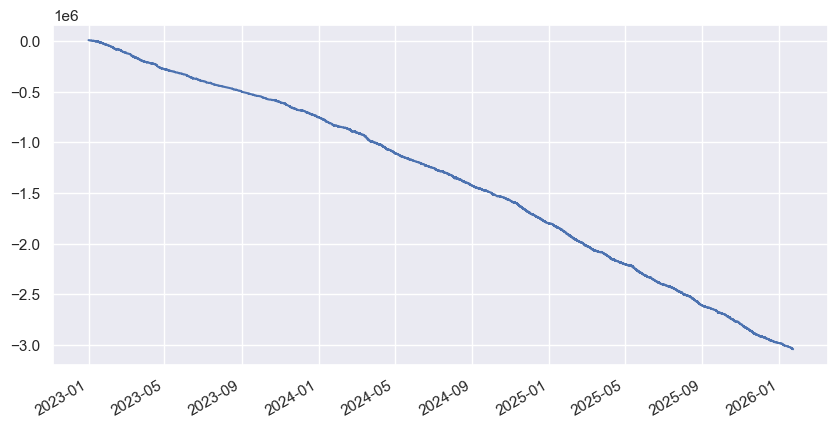

In [19]:
# 
capital_init = 10000
# strategy
step_max = FUTURE_TARGET # 1h15
tp_ratio = target_level #0.45/100 #0.1 / 100 #0.33/100
risk_ratio = 2.5/100

# trading platform
ratio_fees = 0.0774 / 100 # hyperliquid

# display
print("target level for TP [-]: ", tp_ratio)
print("R TP/SL [-]: ", R)
print("r_fees %fees/%TP [-]: ", ratio_fees / tp_ratio)
R_eq = (tp_ratio - ratio_fees) / ((tp_ratio / R) + ratio_fees)
print("R_eq [-]: ", R_eq)



df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(df_feat_tot, capital_init, step_max, tp_ratio, risk_ratio, ratio_fees, R)
)

print("Capital init [$]", capital_init)
print('final capital [$]:', capital)
print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
print("nb_tp: ", nb_tp)
print('capital_tp [$]: ', capital_tp)
print("nb_sl: ", nb_sl)
print('capital_sl [$]: ', capital_sl)
print('nb_neutral: ', nb_neutral)
print('capital_neutral [$]', capital_neutral)

# final capital [$]: -2794488.301003885 # baseline
df_trades["capital"].plot(kind="line", figsize=(10, 5))
df_trades

#### All Next Best Mdl

In [20]:
path_data_old

'data'

In [21]:
r_period_test_old = 0.29071332436069985 #1/ (y_comb_test.shape[0]/(30*288))
r_period_train_old = 0.03221620654167972  #1/ (y_comb.shape[0]/(30*288))

In [22]:
df_hcv = pd.read_csv(os.path.join(path_data_old, "df_hcv_xgb_14_2025-07-20_2025-10-31.csv"), index_col=0)
df_hcv

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,bt_gain_train,bt_nb_days_for_trade_train,bt_gain_test,bt_nb_days_for_trade_test,bt_gain_month_train,bt_gain_month_test
98,21.133831,0.538577,1062.116154,26.745626,0.484211,533.511915,96,98,3,0.732281,0.876955,0.874783,3.975858,2.339111,14946.158829,1.440994,-50.892265,1.000000,483.173238,-16.416860
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,0.517751,0.536595,2.318878,2.930030,10400.045149,2.257908,1897.656144,1.833333,336.208356,646.928231
571,21.166048,0.481638,391.850957,17.733513,0.483051,342.273333,564,571,2,0.779524,0.841754,0.740742,4.414185,2.042931,13079.513166,1.448276,84.103772,1.559322,424.659518,27.425143
572,15.721509,0.500000,451.993378,11.047106,0.511905,390.924366,564,572,2,0.779524,0.841754,0.740742,4.414185,2.042931,17610.112013,1.895492,307.577585,2.315789,571.138768,104.855995
607,17.557833,0.490163,408.498294,12.791386,0.500000,367.752355,564,607,2,0.779524,0.841754,0.740742,4.414185,2.042931,16544.292793,1.725746,597.730586,2.146341,536.571658,203.771791
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,0.841754,0.740742,4.414185,2.042931,15083.952973,1.528926,1629.864861,1.660377,489.209286,555.635748
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,0.735422,0.771859,3.893968,2.276948,11422.402685,2.543956,1263.710897,2.433333,370.056243,519.333245
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,0.735422,0.771859,3.893968,2.276948,13226.994965,2.780781,1571.691320,2.354839,428.520355,645.900543
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,0.735422,0.771859,3.893968,2.276948,12077.064818,2.425197,937.652166,1.921053,392.112494,385.336507


In [23]:
df_hcv_good = df_hcv.copy()[
    (df_hcv["bt_gain_month_test"] > gain_period_min) & (df_hcv["bt_gain_month_train"] > gain_period_min) 
    ].sort_values(by="bt_gain_month_test", ascending=False)
df_hcv_good

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,bt_gain_train,bt_nb_days_for_trade_train,bt_gain_test,bt_nb_days_for_trade_test,bt_gain_month_train,bt_gain_month_test
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,0.517751,0.536595,2.318878,2.930030,10400.045149,2.257908,1897.656144,1.833333,336.208356,646.928231
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,0.735422,0.771859,3.893968,2.276948,13226.994965,2.780781,1571.691320,2.354839,428.520355,645.900543
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,0.841754,0.740742,4.414185,2.042931,15083.952973,1.528926,1629.864861,1.660377,489.209286,555.635748
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,0.735422,0.771859,3.893968,2.276948,11422.402685,2.543956,1263.710897,2.433333,370.056243,519.333245
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,0.735422,0.771859,3.893968,2.276948,12077.064818,2.425197,937.652166,1.921053,392.112494,385.336507


In [24]:
df_hcv_good['bt2_winrate_train'] = np.nan
df_hcv_good['bt2_winrate_test'] = np.nan
df_hcv_good['bt2_gain_train'] = np.nan
df_hcv_good['bt2_gain_test'] = np.nan
df_hcv_good['bt2_nb_days_for_trade_train'] =np.nan
df_hcv_good['bt2_nb_days_for_trade_test'] = np.nan
df_hcv_good["bt2_gain_month_train"] = np.nan
df_hcv_good["bt2_gain_month_test"] = np.nan

for I in range(df_hcv_good.shape[0]):
    rank_best = int(df_hcv_good.iloc[I]["rank"])
    nb_rounds = int(df_hcv_good.iloc[I]["run_index"])
    print("\n--- Model [rank={}, round={}] ---".format(rank_best, nb_rounds))
    xgb_mdl_long = pickle.load(
        open(os.path.join(path_data_old,f'xgb_mdl_14_rank{rank_best}_round{nb_rounds}.pkl'), 'rb'))
    arr_xgb_pred_train = xgb_mdl_long.predict(df_combined_condition)
    arr_xgb_pred = xgb_mdl_long.predict(df_combined_condition_test)
    trade_signal_xgb = pd.Series(
            np.concatenate((arr_xgb_pred_train, arr_xgb_pred), axis=0), 
            index=df_feat_tot.index,
            name="xgb_pred",
    )
    df_trades, capital, nb_tp, nb_sl, nb_neutral, capital_tp, capital_sl, capital_neutral = (
    backtest(df_feat_tot, capital_init, step_max, 
            tp_ratio, risk_ratio, ratio_fees, R,
            trade_signal=trade_signal_xgb)
    )
    df_trades["Train"] = df_trades.index.isin(df_combined_condition.index)
    print("Confusion Matrix:")
    cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
    print(cm)
    print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
    print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
    print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
    print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
    print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
    print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
    print("Backtest:")
    print("Capital init [$]", capital_init)
    print('final capital [$]:', capital)
    print("ratio gain final [-]: ", (capital - capital_init)/capital_init)
    print("Winrate [-] : ", nb_tp / (nb_tp + nb_sl + nb_neutral))
    nb_tp_train = df_trades[(df_trades["Train"] == True) & (df_trades["type"] == "TP")].shape[0] 
    nb_tp_test = df_trades[(df_trades["Train"] == False) & (df_trades["type"] == "TP")].shape[0]
    nb_sl_train = df_trades[(df_trades["Train"] == True) & (df_trades["type"] == "SL")].shape[0]
    nb_sl_test = df_trades[(df_trades["Train"] == False) & (df_trades["type"] == "SL")].shape[0]
    nb_neutral_train = df_trades[(df_trades["Train"] == True) & (df_trades["type"] == "neutral")].shape[0]
    nb_neutral_test = df_trades[(df_trades["Train"] == False) & (df_trades["type"] == "neutral")].shape[0]
    winrate_train = nb_tp_train / (nb_tp_train + nb_sl_train + nb_neutral_train)
    winrate_test = nb_tp_test / (nb_tp_test + nb_sl_test + nb_neutral_test)
    print("Winrate train [-] : ", winrate_train)
    print("Winrate test [-] : ", winrate_test)
    print("nb_tp: ", nb_tp)
    print('capital_tp [$]: ', capital_tp)
    print("nb_sl: ", nb_sl)
    print('capital_sl [$]: ', capital_sl)
    print('nb_neutral: ', nb_neutral)
    print('capital_neutral [$]', capital_neutral)

    nb_days_train = (df_trades[df_trades["Train"] == True].index.max() - df_trades[df_trades["Train"] == True].index.min()).days
    nb_trades_train = df_trades[df_trades["Train"] == True].shape[0]
    gain_month_train = (df_trades[df_trades["Train"] == True].gain.sum()) / nb_days_train * 30 
    print("nb trades on TRAIN : ", nb_trades_train)
    print("nb days on TRAIN : ", nb_days_train)
    print("nb trades per day on TRAIN : ", nb_trades_train / nb_days_train) #nb_trades_test / nb_days_test
    print("nb days for one trade on TRAIN : ", nb_days_train / nb_trades_train)
    print("Gain / month TRAIN : ", gain_month_train)
    nb_days_test = (df_trades[df_trades["Train"] == False].index.max() - df_trades[df_trades["Train"] == False].index.min()).days
    nb_trades_test = df_trades[df_trades["Train"] == False].shape[0] 
    gain_month_test = (df_trades[df_trades["Train"]==False].gain.sum()) / nb_days_test * 30
    print("nb trades on TEST : ", nb_trades_test)
    print("nb days on TEST : ", nb_days_test)
    print("nb trades per day on TEST : ", nb_trades_test / nb_days_test) #nb_trades_test / nb_days_test
    print("nb days for one trade on TEST : ", nb_days_test / nb_trades_test)
    print("Gain / month TEST : ", gain_month_test)

    ser = df_hcv_good.iloc[I].copy()
    ser['bt2_winrate_train'] = winrate_train
    ser['bt2_winrate_test'] = winrate_test
    ser['bt2_nb_days_for_trade_train'] = nb_days_train / nb_trades_train
    ser['bt2_nb_days_for_trade_test'] = nb_days_test / nb_trades_test 
    ser['bt2_gain_train'] = df_trades[df_trades["Train"]==True].gain.sum()
    ser['bt2_gain_test'] = df_trades[df_trades["Train"]==False].gain.sum()
    ser["bt2_gain_month_train"] = gain_month_train
    ser["bt2_gain_month_test"] = gain_month_test
    df_hcv_good.iloc[I] = ser.copy()

    fig = plot_trading_performance(df_trades, df_feat_tot, monthly_target=gain_period_min)
    url_curr = os.path.join(path_data,
        f'xgb_mdl_14_rank{rank_best}_round{nb_rounds}_trade_perf_{df_feat_tot.index.max().strftime("%Y-%m-%d")}.html')
    fig.write_html(url_curr)
    open_webpage_in_chrome(url_curr)



--- Model [rank=70, round=37] ---


/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning: [19:14:45] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:384: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  xgb_mdl_long = pickle.load(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning: [19:14:45] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  xgb_mdl_long = pickle.load(


leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Confusion Matrix:
[[39329    79]
 [14301    46]]
precision TRAIN: 0.501
% possible trades : 0.30
nb trade per day : 0.87
precision TEST: 0.368
% possible trades : 0.23
nb trade per day : 0.67
Backtest:
Capital init [$] 10000
final capital [$]: 18971.642561897323
ratio gain final [-]:  0.8971642561897323
Winrate [-] :  0.46555323590814196
Winrate train [-] :  0.49373433583959897
Winrate test [-] :  0.4
nb_tp:  223
capital_tp [$]:  68679.63431434514
nb_sl:  241
capital_sl [$]:  -60250.0
nb_neutral:  15
capital_neutral [$] 542.008247552473
nb trades on TRAIN :  411
nb days on TRAIN :  928
nb trades per day on TRAIN :  0.44288793103448276
nb days for one trade on TRAIN :  2.2579075425790753
Gain / month TRAIN :  336.2083561064192
nb trades on TEST :  68
nb da

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:14:55] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:384: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:14:55] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.



leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Confusion Matrix:
[[39345    63]
 [14297    50]]
precision TRAIN: 0.505
% possible trades : 0.27
nb trade per day : 0.79
precision TEST: 0.442
% possible trades : 0.21
nb trade per day : 0.61
Backtest:
Capital init [$] 10000
final capital [$]: 23704.549245509035
ratio gain final [-]:  1.3704549245509035
Winrate [-] :  0.4973958333333333
Winrate train [-] :  0.5217391304347826
Winrate test [-] :  0.46938775510204084
nb_tp:  191
capital_tp [$]:  58824.260780448036
nb_sl:  180
capital_sl [$]:  -45000.0
nb_neutral:  13
capital_neutral [$] -119.71153493875912
nb trades on TRAIN :  333
nb days on TRAIN :  926
nb trades per day on TRAIN :  0.3596112311015119
nb days for one trade on TRAIN :  2.780780780780781
Gain / month TRAIN :  428.5203552321821
nb trades on 

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:15:04] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:384: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:15:04] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.



leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Confusion Matrix:
[[39228   180]
 [14231   116]]
precision TRAIN: 0.497
% possible trades : 0.50
nb trade per day : 1.44
precision TEST: 0.392
% possible trades : 0.55
nb trade per day : 1.59
Backtest:
Capital init [$] 10000
final capital [$]: 22913.32840735842
ratio gain final [-]:  1.2913328407358418
Winrate [-] :  0.4718792866941015
Winrate train [-] :  0.4966101694915254
Winrate test [-] :  0.4180327868852459
nb_tp:  344
capital_tp [$]:  105945.26548939355
nb_sl:  368
capital_sl [$]:  -92000.0
nb_neutral:  17
capital_neutral [$] -1031.9370820342967
nb trades on TRAIN :  605
nb days on TRAIN :  925
nb trades per day on TRAIN :  0.654054054054054
nb days for one trade on TRAIN :  1.5289256198347108
Gain / month TRAIN :  489.20928562660936
nb trades on T

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:15:13] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:384: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:15:13] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.



leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Confusion Matrix:
[[39343    65]
 [14297    50]]
precision TRAIN: 0.497
% possible trades : 0.29
nb trade per day : 0.84
precision TEST: 0.435
% possible trades : 0.21
nb trade per day : 0.62
Backtest:
Capital init [$] 10000
final capital [$]: 21591.976543135093
ratio gain final [-]:  1.1591976543135094
Winrate [-] :  0.4830917874396135
Winrate train [-] :  0.5056818181818182
Winrate test [-] :  0.4583333333333333
nb_tp:  200
capital_tp [$]:  61596.084586856596
nb_sl:  200
capital_sl [$]:  -50000.0
nb_neutral:  14
capital_neutral [$] -4.108043721320627
nb trades on TRAIN :  364
nb days on TRAIN :  926
nb trades per day on TRAIN :  0.3930885529157667
nb days for one trade on TRAIN :  2.543956043956044
Gain / month TRAIN :  370.0562425073525
nb trades on TE

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:15:23] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:384: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_83509/1094559510.py:14: UserWarning:

[19:15:23] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.



leverage [-]:  8.269576962347873
Gain for one TP [$]:  307.9804229342824
Loss for one SL [$]:  -250.0
2024-12-12 13:00:00 is not in trade_signal
2024-12-12 13:00:00 is not in trade_signal
trade signal used, adding last buy & date_open
Confusion Matrix:
[[39339    69]
 [14294    53]]
precision TRAIN: 0.496
% possible trades : 0.31
nb trade per day : 0.88
precision TEST: 0.434
% possible trades : 0.23
nb trade per day : 0.65
Backtest:
Capital init [$] 10000
final capital [$]: 22786.540790349896
ratio gain final [-]:  1.2786540790349896
Winrate [-] :  0.48863636363636365
Winrate train [-] :  0.5053763440860215
Winrate test [-] :  0.47368421052631576
nb_tp:  215
capital_tp [$]:  66215.79093087086
nb_sl:  214
capital_sl [$]:  -53500.0
nb_neutral:  11
capital_neutral [$] 70.74985947936511
nb trades on TRAIN :  381
nb days on TRAIN :  924
nb trades per day on TRAIN :  0.41233766233766234
nb days for one trade on TRAIN :  2.425196850393701
Gain / month TRAIN :  392.11249408886766
nb trades on 

In [25]:
df_trades[(df_trades["Train"] == True) & (df_trades["type"] == "TP")].shape[0] 

188

In [26]:
df_hcv_good

,trades_train,precision_train,gain_train,trades_test,precision_test,gain_test,rank,run_index,max_depth,learning_rate,...,bt_gain_month_train,bt_gain_month_test,bt2_winrate_train,bt2_winrate_test,bt2_gain_train,bt2_gain_test,bt2_nb_days_for_trade_train,bt2_nb_days_for_trade_test,bt2_gain_month_train,bt2_gain_month_test
37,13.788536,0.500620,401.186429,13.954240,0.500000,401.184388,70,37,3,0.926477,...,336.208356,646.928231,0.493734,0.400000,10400.045149,-1428.402587,2.257908,2.441176,336.208356,-258.145046
346,11.307888,0.504788,355.286054,9.302826,0.545455,503.200693,55,346,2,0.530952,...,428.520355,645.900543,0.521739,0.469388,13226.994965,477.554281,2.780781,3.000000,428.520355,93.638094
623,19.941832,0.497386,544.266334,16.279946,0.486957,349.669271,564,623,2,0.779524,...,489.209286,555.635748,0.496610,0.418033,15083.952973,-2170.624566,1.528926,1.346774,489.209286,-389.932557
343,12.467672,0.496799,336.196291,9.012113,0.529412,406.871580,55,343,2,0.530952,...,370.056243,519.333245,0.505682,0.458333,11422.402685,169.573858,2.543956,3.060000,370.056243,33.249776
390,12.693185,0.496350,339.100034,11.047106,0.506667,358.664772,55,390,2,0.530952,...,392.112494,385.336507,0.505376,0.473684,12077.064818,709.475972,2.425197,2.593220,392.112494,139.112936


In [27]:
# save 
df_hcv_good.to_csv(os.path.join(
    path_data,
    f"df_hcv_good_xgb_14_{
        df_combined_condition.index.max().strftime("%Y-%m-%d")
    }_{
        df_combined_condition_test.index.max().strftime("%Y-%m-%d")
    }.csv",
))

In [28]:
(int(268188/3))/288 - 3*60

130.40277777777777

In [29]:
(int(268188/2/2))/288  - 3*60

52.80208333333334

In [30]:
(int(268188/2/2))/288

232.80208333333334

In [31]:
23380 
23688 
23014 
22764

22764

In [32]:
23014 - 23688

-674

In [33]:
# last capital of last month - last cap of this month
23014 - 23380

-366